# this notebook contains code which is trianable

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# initial processing

# pipeline starts

In [ ]:
!pip install DeepFace


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 58.6 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117030 sha256=076dc00c96718e6551ed1ffbac77b22edea24356e8f8e4530ddb779aea8c92fa
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
Successfully built fire


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import Dataset, DataLoader
from deepface import DeepFace
import numpy as np
import os

24-09-12 07:31:54 - Directory /root/.deepface has been created
24-09-12 07:31:54 - Directory /root/.deepface/weights has been created


In [ ]:
from retinaface import RetinaFace
import cv2
import numpy as np
import os

# Function to calculate brightness
def calculate_brightness(img):
    return np.mean(cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[:,:,2])

# Function to calculate contrast
def calculate_contrast(img):
    return img.std()

# Function to calculate noise
def calculate_noise(img):
    return np.var(img)

# Function to calculate sharpness using Laplacian
def calculate_sharpness(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

# Function to calculate the alignment of the face
def calculate_alignment(landmarks):
    left_eye = np.array(landmarks['left_eye'])
    right_eye = np.array(landmarks['right_eye'])
    delta_y = right_eye[1] - left_eye[1]
    delta_x = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(delta_y, delta_x))
    return abs(angle)

# Function to check if the eyes, nose, and ears are parallel
def are_features_parallel(face_info):
    landmarks = face_info['landmarks']
    eye_left = landmarks['left_eye']
    eye_right = landmarks['right_eye']
    nose = landmarks['nose']
    ear_left = landmarks.get('left_ear', None)
    ear_right = landmarks.get('right_ear', None)

    # Check if eyes are parallel (difference in y-coordinates should be minimal)
    eyes_parallel = abs(eye_left[1] - eye_right[1]) < 20  # Increased tolerance

    # Check if nose is centered between the eyes
    nose_centered = abs(nose[0] - (eye_left[0] + eye_right[0]) / 2) < 20  # Increased tolerance

    # Check if ears are parallel (optional, depends on availability)
    ears_parallel = True
    if ear_left is not None and ear_right is not None:
        ears_parallel = abs(ear_left[1] - ear_right[1]) < 20  # Increased tolerance

    return eyes_parallel and nose_centered and ears_parallel

# Function to process images from a folder
def process_images(input_folder, output_folder, threshold_values):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(input_folder, filename)
            img = cv2.imread(img_path)

            # Detect faces using RetinaFace
            faces = RetinaFace.detect_faces(img)

            if isinstance(faces, dict):
                for face_id, face_info in faces.items():
                    x1, y1, x2, y2 = face_info['facial_area']
                    face_img = img[y1:y2, x1:x2]  # Crop the face

                    # Calculate features on the cropped face
                    brightness = calculate_brightness(face_img)
                    contrast = calculate_contrast(face_img)
                    noise = calculate_noise(face_img)
                    # sharpness = calculate_sharpness(face_img)
                    alignment = calculate_alignment(face_info['landmarks'])

                    print(f'Processing {filename} - Brightness: {brightness}, Contrast: {contrast}, Noise: {noise}, Sharpness: {sharpness}, Alignment Angle: {alignment}')

                    # Apply thresholds
                    if (brightness > threshold_values['brightness'] and
                        contrast < threshold_values['contrast'] and
                        noise < threshold_values['noise'] and
                        # sharpness > threshold_values['sharpness'] and
                        alignment < threshold_values['alignment']):

                        if are_features_parallel(face_info):
                            # Save the accepted face image
                            output_path = os.path.join(output_folder, filename)
                            cv2.imwrite(output_path, face_img)
                            print(f'Image {filename} accepted and saved to {output_path}')
                        else:
                            print(f'Image {filename} rejected due to misaligned facial features')
                    else:
                        print(f'Image {filename} rejected due to low quality features or poor alignment')

# Define threshold values
threshold_values = {
    'brightness': 100,
    'contrast': 60,
    'noise': 3500,
    # 'sharpness': 150,  # Adjusted based on the Laplacian variance scale
    'alignment': 180
}

# Process images in a folder
input_folder = '/content/drive/My Drive/dataset_train'
output_folder = '/content/drive/My Drive/Cropped_Faces'
process_images(input_folder, output_folder, threshold_values)


In [ ]:
# Assuming you have a directory with images organized in subfolders for each class
dir = '/content/drive/My Drive/Cropped_Faces'
imgfolders = [os.path.join(dir, folder) for folder in os.listdir(dir)]
# List to store paths of all images
imgpaths = []
for folder in imgfolders:
    for path in os.listdir(folder):
        imgpaths.append(os.path.join(folder, path))

In [ ]:
import cv2
import numpy as np
from deepface import DeepFace
import os

def normalize_brightness_contrast_grayscale(image):
    # Normalize brightness using LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l = cv2.equalizeHist(l)
    lab = cv2.merge((l, a, b))
    normalized_image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    # Contrast normalization using CLAHE
    lab = cv2.cvtColor(normalized_image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    normalized_contrast_image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    # Convert to grayscale
    gray_image = cv2.cvtColor(normalized_contrast_image, cv2.COLOR_BGR2GRAY)

    return gray_image

def get_all_embeddings(img_paths, save_directory="/content/drive/MyDrive/D9"):
    # Create directory if it doesn't exist
    os.makedirs(save_directory, exist_ok=True)

    embeddings = []
    for img_path in img_paths:
        image = cv2.imread(img_path)

        # Normalize brightness, contrast, and convert to grayscale
        processed_image = normalize_brightness_contrast_grayscale(image)

        # Generate a new filename
        base_name = os.path.basename(img_path)
        name, ext = os.path.splitext(base_name)
        processed_image_path = os.path.join(save_directory, f"{name}_processed{ext}")


        # Save the processed image
        cv2.imwrite(processed_image_path, processed_image)

        embedding = DeepFace.represent(img_path=processed_image_path, model_name="Facenet512", detector_backend='skip')
        embarr = np.array(embedding[0]["embedding"])
        embeddings.append(embarr)


    return np.array(embeddings)

all_embeddings = get_all_embeddings(imgpaths)
print("Shape of all_embeddings:", all_embeddings.shape)  # Should be (num_images, 512)

# Convert embeddings to PyTorch tensors
X = torch.tensor(all_embeddings, dtype=torch.float32)

# Assuming you have ground truth labels for each image class
######################################################################################################3
# Here, creating dummy labels assuming 5 classes  now 9 classes  now 12 classses    now 20 classes                      ## if there is any change in no of clssses append thghis
########################################################################################################################
#y = torch.tensor([i // (len(X) // 20) for i in range(len(X))], dtype=torch.long)  # Adjust as per your dataset

# Assuming you have 20 classes and 8 images per class
num_classes = 2
images_per_class = 11

# Generate labels
y = torch.tensor([i // images_per_class for i in range(num_classes * images_per_class)], dtype=torch.long)


# Custom Dataset class
class EmbeddingsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(0), self.y[idx]  # Add sequence dimension


# Create DataLoader
dataset = EmbeddingsDataset(X, y)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Check the DataLoader
for data in dataloader:
    inputs, labels = data
    print(inputs.shape, labels)
    break  # Print one batch and break to avoid clutter

Shape of all_embeddings: (22, 512)
torch.Size([1, 1, 512]) tensor([1])


In [ ]:
# Save embeddings and labels using torch
save_path = '/content/drive/MyDrive/emb_D9'
os.makedirs(save_path, exist_ok=True)
torch.save(X, os.path.join(save_path, 'all_embeddings.pt'))
torch.save(y, os.path.join(save_path, 'labels.pt'))

print("Embeddings and labels saved successfully.")

Embeddings and labels saved successfully.


In [ ]:
import torch

# Load embeddings and labels using torch
save_path = '/content/drive/MyDrive/emb_with_prep/Model_weights And Embeddings'
loaded_embeddings = torch.load(os.path.join(save_path, 'all_embeddings.pt'))
loaded_labels = torch.load(os.path.join(save_path, 'labels.pt'))
X = loaded_embeddings
y = loaded_labels

print("Loaded embeddings shape:", loaded_embeddings.shape)  # Should be (num_images, 512)
print("Loaded labels shape:", loaded_labels.shape)  # Should match the number of images


Loaded embeddings shape: torch.Size([460, 512])
Loaded labels shape: torch.Size([460])


In [ ]:
y.shape

torch.Size([460])

# teacher student model

In [ ]:
# Assuming the teacher model is pre-trained on 23 classes
teacher_model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)
teacher_model.load_state_dict(torch.load("/content/drive/MyDrive/pretrained_teacher_model.pth"))  # Path to the pre-trained model
teacher_model.eval()  # Set the model to evaluation mode


In [ ]:
# # @title
# # Custom Dataset class
# class EmbeddingsDataset(Dataset):
#     def __init__(self, X, y):
#         self.X = X
#         self.y = y

#     def __len__(self):
#         return len(self.y)

#     def __getitem__(self, idx):
#         return self.X[idx].unsqueeze(0), self.y[idx]  # Add sequence dimension

# # Create DataLoader
# dataset = EmbeddingsDataset(X, y)
# dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# # Check the DataLoader
# for data in dataloader:
#     inputs, labels = data
#     print(inputs.shape, labels)
#     break  # Print one batch and break to avoid clutter

torch.Size([1, 1, 512]) tensor([7])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils

class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiply by 2 because of bidirection

    def forward(self, x, lengths):
        # Pack the sequence
        packed_input = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hn, _) = self.lstm(packed_input)

        # Concatenate the forward and backward hidden states
        out = self.fc(torch.cat((hn[-2], hn[-1]), dim=1))  # Take the last hidden state from both directions
        return out

# Model parameters
input_dim = 512  # Dimension of the Facenet512 embeddings
hidden_dim = 256
output_dim = 128  # Output dimension of the LSTM
num_layers = 4  # Number of LSTM layers

# Instantiate the BiLSTM model
model = BiLSTMModel(input_dim, hidden_dim, output_dim, num_layers)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Define the LSTM model with output dimension 128
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths):
        # Pack the sequence
        packed_input = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hn, _) = self.lstm(packed_input)
        # We only need the last hidden state
        out = self.fc(hn[-1])
        return out

# Model parameters
input_dim = 512  # Dimension of the Facenet512 embeddings
hidden_dim = 256
output_dim = 128  # Output dimension of the LSTM
num_layers = 4  # Number of LSTM layers

# Instantiate the model
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [1/20], Loss: 2.4577
Epoch [2/20], Loss: 0.7904
Epoch [3/20], Loss: 0.3631
Epoch [4/20], Loss: 0.0413
Epoch [5/20], Loss: 0.0075
Epoch [6/20], Loss: 0.0037
Epoch [7/20], Loss: 0.0022
Epoch [8/20], Loss: 0.0015
Epoch [9/20], Loss: 0.0010
Epoch [10/20], Loss: 0.0007
Epoch [11/20], Loss: 0.0005
Epoch [12/20], Loss: 0.0004
Epoch [13/20], Loss: 0.0003
Epoch [14/20], Loss: 0.0002
Epoch [15/20], Loss: 0.0002
Epoch [16/20], Loss: 0.0001
Epoch [17/20], Loss: 0.0001
Epoch [18/20], Loss: 0.0001
Epoch [19/20], Loss: 0.0001
Epoch [20/20], Loss: 0.0000


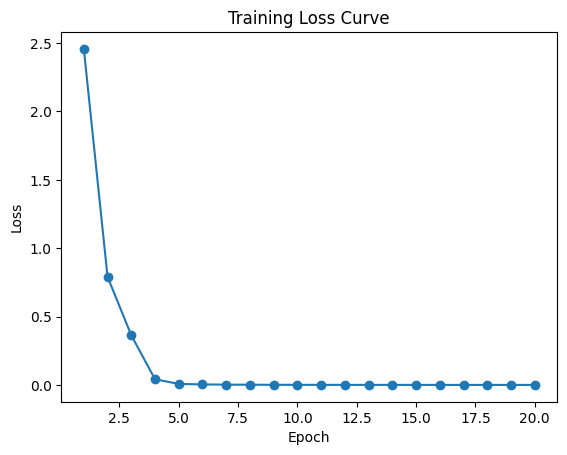

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
# Training loop

# List to store loss values
losses = []
num_epochs = 20
for epoch in range(num_epochs):
    epoch_loss = 0
    for inputs, labels in dataloader:
        # Get the lengths of sequences
        lengths = torch.tensor([inputs.shape[1]])  # Assuming all sequences have the same length

        # Forward pass
        outputs = model(inputs, lengths)
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Plot the loss curve
plt.plot(range(1, num_epochs+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()



In [ ]:
lstm_no_aug_path = '/content/drive/MyDrive/emb_D9/lstm_no_prep.pth'  # Adjust the path as needed
torch.save(model.state_dict(), lstm_no_aug_path)

#torch.save(model.state_dict(), 'lstm_model_128.pth')

In [ ]:
lstm_no_aug_path = '/content/drive/MyDrive/bilstm_no_prep.pth'  # Adjust the path as needed
torch.save(model.state_dict(), lstm_no_aug_path)


In [ ]:
# import torch
# import numpy as np
# import os
# import cv2
# from deepface import DeepFace
# import matplotlib.pyplot as plt
# from collections import defaultdict

# # Block 1: Code for Loading Class Embeddings and Rounding Off
# model.load_state_dict(torch.load(lstm_no_aug_path))
# model.eval()

# def get_lengths(batch_size):
#     return torch.ones(batch_size, dtype=torch.long)

# class_vectors = defaultdict(list)
# with torch.no_grad():
#     for inputs, labels in dataloader:
#         lengths = get_lengths(inputs.size(0))  # Get lengths for the current batch
#         class_vector = model(inputs, lengths)
#         class_vectors[labels.item()].append(class_vector.squeeze().numpy())

# rounded_class_vectors = {class_num: [np.round(vector, 0) for vector in vectors] for class_num, vectors in class_vectors.items()}

# save_dir = 'path/to/save/embeddings'
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

# for class_num, vectors in rounded_class_vectors.items():
#     for idx, vector in enumerate(vectors):
#         np.save(os.path.join(save_dir, f'class_{class_num}_vector_{idx}.npy'), vector)

# # Block 2: Code for Getting Image Embedding without Preprocessing
# def get_initial_image_embedding(image_path):
#     embedding = DeepFace.represent(img_path=image_path, model_name="Facenet512", detector_backend='skip')
#     embarr = np.array(embedding[0]["embedding"])
#     return torch.tensor(embarr, dtype=torch.float32).unsqueeze(0).unsqueeze(1)

# def get_final_image_embedding(image_path, model):
#     initial_embedding = get_initial_image_embedding(image_path)
#     lengths = torch.tensor([initial_embedding.shape[1]]) # Sequence length is 1
#     with torch.no_grad():
#         final_embedding = model(initial_embedding, lengths)
#     return final_embedding

# # Block 3: Code for Comparing New Image Embedding
# def load_all_embeddings(save_dir):
#     all_embeddings = defaultdict(list)
#     for file in os.listdir(save_dir):
#         if file.endswith('.npy'):
#             class_num = int(file.split('_')[1])
#             vector = np.load(os.path.join(save_dir, file))
#             all_embeddings[class_num].append(torch.tensor(vector, dtype=torch.float32))
#     return all_embeddings

# def compare_with_tolerance(embedding1, embedding2, tolerance=0.1):
#     return torch.sum(torch.abs(embedding1 - embedding2) <= tolerance).item()

# def compare_new_image(image_path, model, save_dir, tolerance=0.1):
#     new_image_final_embedding = get_final_image_embedding(image_path, model)
#     all_embeddings = load_all_embeddings(save_dir)

#     new_image_final_embedding_rounded = torch.round(new_image_final_embedding)

#     print(f"New Image Embedding:\n{new_image_final_embedding_rounded.squeeze().numpy()}")

#     for class_num, vectors in all_embeddings.items():
#         print(f"\nClass {class_num}:")

#         # Print comparisons between new image embedding and each vector in the class
#         for i, vector in enumerate(vectors):
#             vector_rounded = torch.round(vector)
#             matching_count = compare_with_tolerance(new_image_final_embedding_rounded, vector_rounded, tolerance)
#             print(f"Comparison with Class {class_num} Vector {i}: {matching_count} matching values")

#     # Optionally plot comparisons for visual inspection
#     # for class_num, vectors in all_embeddings.items():
#     #     for i, vector in enumerate(vectors):
#     #         plt.figure(figsize=(10, 6))
#     #         plt.plot(range(128), vector.numpy(), label=f'Class {class_num} Vector {i}')
#     #         plt.plot(range(128), new_image_final_embedding_rounded.squeeze().numpy(), label='New Image Embedding')
#     #         plt.xlabel('Index')
#     #         plt.ylabel('Value')
#     #         plt.title(f'Comparison of Class {class_num} Vector {i} and New Image Embedding')
#     #         plt.legend()
#     #         plt.show()

# # Test with a new image
# new_image_path = '/content/drive/MyDrive/FaceScan_D8_no_bg2/Test/Ajay/20240826_181953.jpg'
# compare_new_image(new_image_path, model, save_dir)


remove bg in test image

In [ ]:
import os
import cv2
from retinaface import RetinaFace
def crop_faces(image_path, output_folder):
    # Load the image
    img = cv2.imread(image_path)
    # Detect faces
    faces = RetinaFace.detect_faces(image_path)

    if faces:
        for i, face in enumerate(faces.values()):
            facial_area = face['facial_area']
            # Crop face from the image
            cropped_face = img[facial_area[1]:facial_area[3], facial_area[0]:facial_area[2]]
            # Save cropped face
            output_path = os.path.join(output_folder, f'face_{i}.jpg')
            cv2.imwrite(output_path, cropped_face)
def process_folders(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for folder_name in os.listdir(input_folder):
        folder_path = os.path.join(input_folder, folder_name)
        output_subfolder = os.path.join(output_folder, folder_name)

        if not os.path.exists(output_subfolder):
            os.makedirs(output_subfolder)

        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    crop_faces(file_path, output_subfolder)
input_folder = '/content/drive/MyDrive/New_test'  #input raw test image
output_folder = '/content/drive/MyDrive/New_test_cropped' #saved after retinaface cropped image

process_folders(input_folder, output_folder)


In [ ]:
def normalize_brightness_contrast_grayscale(image):
    # Normalize brightness using LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l = cv2.equalizeHist(l)
    lab = cv2.merge((l, a, b))
    normalized_image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    # Contrast normalization using CLAHE
    lab = cv2.cvtColor(normalized_image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    normalized_contrast_image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    # Convert to grayscale
    gray_image = cv2.cvtColor(normalized_contrast_image, cv2.COLOR_BGR2GRAY)

    return gray_image

In [ ]:
import torch
import numpy as np
import os
import cv2
from deepface import DeepFace
import matplotlib.pyplot as plt
from collections import defaultdict  # Add this import

# Block 1: Code for Loading Class Embeddings and Rounding Off
model.load_state_dict(torch.load(lstm_no_aug_path))
model.eval()

def get_lengths(batch_size):
    return torch.ones(batch_size, dtype=torch.long)

class_vectors = defaultdict(list)
with torch.no_grad():
    for inputs, labels in dataloader:
        lengths = get_lengths(inputs.size(0))  # Get lengths for the current batch
        class_vector = model(inputs, lengths)
        class_vectors[labels.item()].append(class_vector.squeeze().numpy())

rounded_class_vectors = {class_num: [np.round(vector, 0) for vector in vectors] for class_num, vectors in class_vectors.items()}

save_dir = 'path1/to/save/embeddings'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for class_num, vectors in rounded_class_vectors.items():
    for idx, vector in enumerate(vectors):
        np.save(os.path.join(save_dir, f'class_{class_num}_vector_{idx}.npy'), vector)

# Block 2: Code for Getting Image Embedding
def get_initial_image_embedding(image_path):
    image = cv2.imread(image_path)
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    processed_image = normalize_brightness_contrast_grayscale(image)
    if len(processed_image.shape) == 2:
        processed_image = cv2.cvtColor(processed_image, cv2.COLOR_GRAY2RGB)
    embedding = DeepFace.represent(img_path=processed_image, model_name="Facenet512", detector_backend='skip')
    embarr = np.array(embedding[0]["embedding"])
    return torch.tensor(embarr, dtype=torch.float32).unsqueeze(0).unsqueeze(1)

def get_final_image_embedding(image_path, model):
    initial_embedding = get_initial_image_embedding(image_path)
    lengths = torch.tensor([initial_embedding.shape[1]])  # Sequence length is 1
    with torch.no_grad():
        final_embedding = model(initial_embedding, lengths)
    return final_embedding

# Block 3: Code for Comparing New Image Embedding
def load_all_embeddings(save_dir):
    all_embeddings = defaultdict(list)
    for file in os.listdir(save_dir):
        if file.endswith('.npy'):
            class_num = int(file.split('_')[1])
            vector = np.load(os.path.join(save_dir, file))
            all_embeddings[class_num].append(torch.tensor(vector, dtype=torch.float32))
    return all_embeddings

def compare_with_tolerance(embedding1, embedding2, tolerance=0.1):
    return torch.sum(torch.abs(embedding1 - embedding2) <= tolerance).item()

def compare_new_image(image_path, model, save_dir, tolerance=0.1):
    new_image_final_embedding = get_final_image_embedding(image_path, model)
    all_embeddings = load_all_embeddings(save_dir)

    new_image_final_embedding_rounded = torch.round(new_image_final_embedding)

    print(f"New Image Embedding:\n{new_image_final_embedding_rounded.squeeze().numpy()}")

    for class_num, vectors in all_embeddings.items():
        print(f"\nClass {class_num}:")

        # Print comparisons between new image embedding and each vector in the class
        for i, vector in enumerate(vectors):
            vector_rounded = torch.round(vector)
            matching_count = compare_with_tolerance(new_image_final_embedding_rounded, vector_rounded, tolerance)
            print(f"Comparison with Class {class_num} Vector {i}: {matching_count} matching values")
# Test with a new image
new_image_path = '/content/drive/MyDrive/28thnight/FaceScan_D8_no_bg2/Test/Lab3/IMG_20240821_150911746_HDR.jpg'
compare_new_image(new_image_path, model, save_dir)


New Image Embedding:
[-0.  7. -0. -1. -1. -1. -1. -0. -1. 19.  3. -0.  5. -4. -3.  7.  0.  5.
 -1.  1. -3.  4. -1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.
  0.  0.  0. -0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0. -0.  0.  0.  0. -0.  0.  0.  0. -0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.
  0.  0.]

Class 20:
Comparison with Class 20 Vector 0: 0 matching values
Comparison with Class 20 Vector 1: 0 matching values
Comparison with Class 20 Vector 2: 0 matching values
Comparison with Class 20 Vector 3: 0 matching values
Comparison with Class 20 Vector 4: 0 matching values
Comparison with Class 20 Vector 5: 0 matching values
Comparison with Class 20 Vector 6: 0 matching values
Comparison with Class 20 Vector 7: 0 matching values
Comparison with Class 2

----------------

In [ ]:
import torch
import numpy as np
import os
import cv2
from deepface import DeepFace
import matplotlib.pyplot as plt

def normalize_brightness_contrast_grayscale(image):
    # Normalize brightness using LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l = cv2.equalizeHist(l)
    lab = cv2.merge((l, a, b))
    normalized_image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    # Contrast normalization using CLAHE
    lab = cv2.cvtColor(normalized_image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    normalized_contrast_image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    # Convert to grayscale
    gray_image = cv2.cvtColor(normalized_contrast_image, cv2.COLOR_BGR2GRAY)

    return gray_image

# Block 1: Code for Loading the Model
model.load_state_dict(torch.load(lstm_no_aug_path))
model.eval()

def get_lengths(batch_size):
    return torch.ones(batch_size, dtype=torch.long)

# Block 2: Code for Getting Image Embedding (Preprocessing Integrated)
def get_initial_image_embedding(image_path):
    image = cv2.imread(image_path)

    # Apply preprocessing
    gray_image = normalize_brightness_contrast_grayscale(image)

    # Since DeepFace expects a 3-channel image, convert grayscale to RGB
    image_rgb = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)

    embedding = DeepFace.represent(img_path=image_rgb, model_name="Facenet512", detector_backend='skip')
    embarr = np.array(embedding[0]["embedding"])
    return torch.tensor(embarr, dtype=torch.float32).unsqueeze(0).unsqueeze(1)

def get_final_image_embedding(image_path, model):
    initial_embedding = get_initial_image_embedding(image_path)
    lengths = torch.tensor([initial_embedding.shape[1]])  # Sequence length is 1
    with torch.no_grad():
        final_embedding = model(initial_embedding, lengths)
    return final_embedding

# Block 3: Code for Comparing Embeddings
def compare_with_tolerance(embedding1, embedding2, tolerance=0.1):
    return torch.sum(torch.abs(embedding1 - embedding2) <= tolerance).item()

def compare_embeddings_in_folder(folder_path, model, tolerance=0.1):
    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))])[:10]  # Take first 20 images
    embeddings = []
    count_128_matches = 0  # Initialize a counter for 128 matching values

    # Compute embeddings for the selected images
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        final_embedding = get_final_image_embedding(image_path, model)
        final_embedding_rounded = torch.round(final_embedding)
        embeddings.append((image_file, final_embedding_rounded))

    # Print all embeddings
    print("\nTest Image Embeddings:")
    for image_file, embedding in embeddings:
        print(f"\nImage: {image_file}")
        print(embedding.squeeze().numpy())

    # Compare embeddings with each other
    print("\nComparisons Between Test Image Embeddings:")
    for i in range(len(embeddings)):
        for j in range(i + 1, len(embeddings)):
            image_file_i, embedding_i = embeddings[i]
            image_file_j, embedding_j = embeddings[j]
            matching_count = compare_with_tolerance(embedding_i, embedding_j, tolerance)

            if matching_count == 128:
                count_128_matches += 1  # Increment the counter if 128 matching values are found

            print(f"\nComparison between {image_file_i} and {image_file_j}: {matching_count} matching values")

    # Print the final count of 128 matching values
    print(f"\nNumber of comparisons with exactly 128 matching values: {count_128_matches}")

# Specify the folder containing images
folder_path = '/content/drive/MyDrive/28thnight/FaceScan_D8_no_bg2/Test/Shubham'  # change this
compare_embeddings_in_folder(folder_path, model)
/content/drive/MyDrive/28thnight/FaceScan_D8_no_bg2/Test/Ajay


Test Image Embeddings:

Image: 20240817_165402.jpg
[-1. -4.  1.  9. -1. -4. -2. -2. -1. -5. -3.  2. -3.  3. -1. -4.  3. -4.
 -4. -2. -5. -4.  1. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5.
 -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5.
 -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5.
 -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5.
 -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5.
 -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -4. -5. -5.
 -5. -5.]

Image: 20240817_165403.jpg
[-2. -4. -1.  7. -0. -3. -2. -2. -1. -4. -3.  1. -2.  5. -1. -3.  3. -4.
 -4. -1. -4. -4.  1. -4. -4. -5. -4. -4. -5. -5. -5. -5. -5. -5. -4. -5.
 -5. -4. -5. -5. -5. -4. -5. -4. -4. -5. -4. -5. -4. -4. -5. -5. -5. -4.
 -5. -4. -5. -5. -4. -4. -5. -4. -4. -5. -5. -5. -4. -4. -5. -4. -5. -4.
 -4. -4. -5. -4. -4. -4. -5. -5. -4. -4. -5. -5. -4. -4. -4. -4. -4. -5.
 -5. -4. -4. -5. -5. -4. -4. -4. -